In [9]:
import csv
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, log_loss
import seaborn as sns
import os
import ast
import sys
import re
from statistics import mean, stdev
statistics_path = os.path.abspath("../")
sys.path.append(statistics_path)
import stats_utils
from matplotlib.ticker import MaxNLocator

In [10]:
path_to_exp_statistics = "/Users/admin/Desktop/thesis/dataset/metrics/"
path_to_exp_images = "/Users/admin/Desktop/thesis_writing/experiment_images/performance_exp/2_label_skew/"

### 1. Compare the 3 different levels of skewness (1/6 missing, 3/6 missing, 5/6 missing)

In [11]:
labels_names_list = []
exp_name = "exp_2_1_1_dataset_1"
skew_1 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

exp_name = "exp_2_2_1_dataset_1"
skew_2 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

exp_name = "exp_2_3_1_dataset_1"
skew_3 = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

dfs = [skew_1, skew_2, skew_3]

In [13]:
# def plot_acc_loss_from_dfs(dfs, get_accuracy_loss_values, path_to_exp_images, should_save=False, filename="accuracies_for_every_dataset", label_names=None):
#     accs = {}
#     losses = {}

#     for i, df in enumerate(dfs):
#         label_name = label_names[i]
#         first_client_name = ast.literal_eval(df['devices_names'][0])[0]
#         acc, loss = get_accuracy_loss_values(df, first_client_name)
#         accs[label_name] = acc
#         losses[label_name] = loss

#     rounds = range(1, len(next(iter(accs.values()))) + 1)

#     # Plot Accuracy
#     plt.figure(figsize=(10, 6))
#     for name, values in accs.items():
#         plt.plot(rounds, values, label=name)
#     plt.title("Accuracy per Round")
#     plt.xlabel("Federated Round")
#     plt.ylabel("Accuracy")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     if should_save == False:
#         plt.show()
#     else:
# #         filename = "accuracies_for_every_dataset"
#         path_to_file = os.path.join(path_to_exp_images, filename)
#         plt.savefig(path_to_file, dpi=300)
#         plt.close()

In [16]:
def plot_acc_loss_from_dfs(
    dfs,
    get_accuracy_loss_values,
    path_to_exp_images,
    should_save=False,
    filename="accuracies_for_every_dataset",
    label_names=None,
    title=""
):
    accs = {}
    losses = {}

    # 1) Extract accuracy & loss per dataset
    for i, df in enumerate(dfs):
        label = label_names[i]
        first_client = ast.literal_eval(df["devices_names"][0])[0]
        acc, loss = get_accuracy_loss_values(df, first_client)
        accs[label] = acc
        losses[label] = loss

    # 2) X-axis is 1…n_rounds
    n_rounds = len(next(iter(accs.values())))
    rounds = list(range(1, n_rounds + 1))

    # 3) Plot Accuracy
    fig, ax = plt.subplots(figsize=(10, 6))
    for label, values in accs.items():
        ax.plot(rounds, values, label=label)

    ax.set_title(title)
    ax.set_xlabel("Federated Round")
    ax.set_ylabel("Accuracy")
    ax.grid(True)
    ax.legend()

    # 4) Force integer ticks and explicitly include 1 and n_rounds
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(rounds)       # ensures the full range from 1 to n_rounds is shown

    plt.tight_layout()

    # 5) Show or save
    if not should_save:
        plt.show()
    else:
        path_to_file = os.path.join(path_to_exp_images, filename + ".png")
        fig.savefig(path_to_file, dpi=300)
        plt.close(fig)

In [19]:
filename = "levels_of_label_skew"
title = "Accuracy Across Varying Levels of Label Skew"
label_names = ["1/6 skew", "3/6 skew", "5/6 skew"]
plot_acc_loss_from_dfs(dfs, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                       should_save=True, filename=filename, label_names=label_names, title=title)

### 2. Save the confusion matrics for the 3 levels of skew

In [14]:
def generate_confusion_matrix_only(y_true, y_pred, label_names, path_to_exp_logs, filename, figsize=(8,6)):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create and configure plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
#     plt.show()
    
    # Save plot
    path_to_file = os.path.join(path_to_exp_logs, filename)
    plt.savefig(path_to_file, dpi=300)
    plt.close()

In [15]:
idx = 0
for df, labels in zip(dfs, labels_names_list):
    first_client_name = ast.literal_eval(df['devices_names'][0])[0]
    y_true = json.loads(df['y_true'].iloc[-1])[first_client_name]
    y_pred = json.loads(df['y_pred'].iloc[-1])[first_client_name]
    idx += 1
    filename = "confusion_matrix_skew_level_" + str(idx)
    generate_confusion_matrix_only(y_true, y_pred, labels, path_to_exp_images,filename)

### 3. For every label skew level compare the 1 client case 

In [21]:
labels_names_list_single_client = []
exp_name = "exp_2_1_1_dataset_1_single_client"
skew_1_single_client = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list_single_client.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

exp_name = "exp_2_2_1_dataset_1_single_client"
skew_2_single_client = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list_single_client.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

exp_name = "exp_2_3_1_dataset_1_single_client"
skew_3_single_client = stats_utils.parse_experiments_statistics_to_df(path_to_exp_statistics, exp_name, csv_filename="logs.csv")
labels_names_list_single_client.append(stats_utils.load_label_names(path_to_exp_statistics, exp_name))

dfs_single_client = [skew_1_single_client, skew_2_single_client, skew_3_single_client]

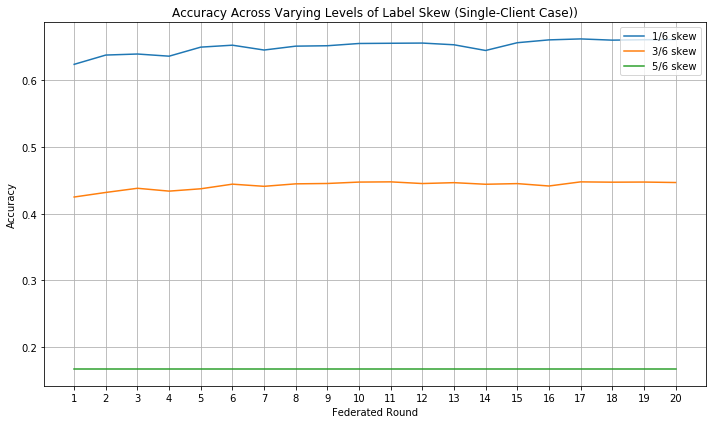

In [24]:
filename = "levels_of_label_skew_single_client_case"
title = "Accuracy Across Varying Levels of Label Skew (Single-Client Case))"
label_names = ["1/6 skew", "3/6 skew", "5/6 skew"]
plot_acc_loss_from_dfs(dfs_single_client, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                       should_save=False, filename=filename, label_names=label_names, title=title)

In [23]:
idx = 0
for df, labels in zip(dfs_single_client, labels_names_list_single_client):
    first_client_name = ast.literal_eval(df['devices_names'][0])[0]
    y_true = json.loads(df['y_true'].iloc[-1])[first_client_name]
    y_pred = json.loads(df['y_pred'].iloc[-1])[first_client_name]
    idx += 1
    filename = "confusion_matrix_skew_level_with_single_client" + str(idx)
    generate_confusion_matrix_only(y_true, y_pred, labels, path_to_exp_images,filename)

### 4. For every skew level compare the single client with the 5 client case

In [26]:
### 1/6 skew
filename = "skew_level_1_6_single_vs_multiple_clients"
title = "Comparison of 1/6 Label Skew: Single Client vs. 5 Clients"
label_names = ["1/6 skew (5 clients)", "1/6 skew (1 client)"]
dfs = [skew_1, skew_1_single_client]
plot_acc_loss_from_dfs(dfs, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                       should_save=False, filename=filename, label_names=label_names, title=title)

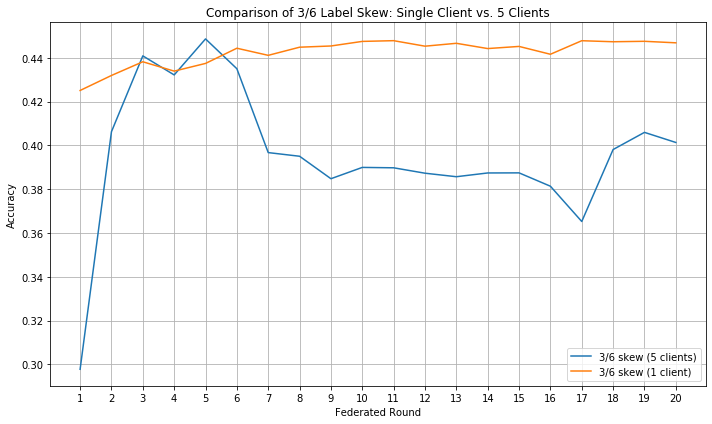

In [28]:
### 3/6 skew
filename = "skew_level_3_6_single_vs_multiple_clients"
title = "Comparison of 3/6 Label Skew: Single Client vs. 5 Clients"
label_names = ["3/6 skew (5 clients)", "3/6 skew (1 client)"]
dfs = [skew_2, skew_2_single_client]
plot_acc_loss_from_dfs(dfs, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                       should_save=False, filename=filename, label_names=label_names, title=title)

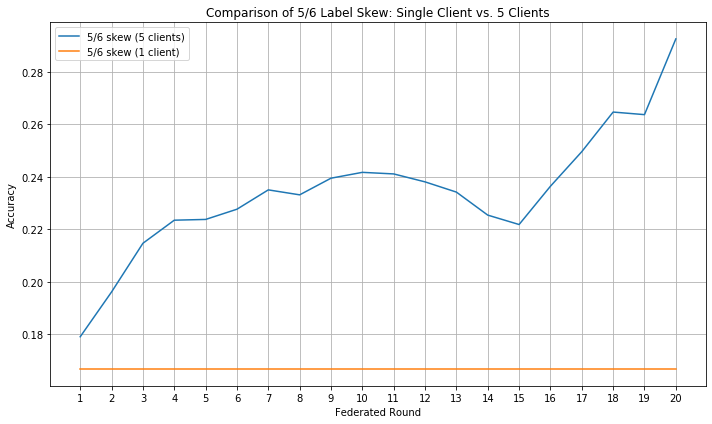

In [30]:
### 5/6 skew
filename = "skew_level_5_6_single_vs_multiple_clients"
title = "Comparison of 5/6 Label Skew: Single Client vs. 5 Clients"
label_names = ["5/6 skew (5 clients)", "5/6 skew (1 client)"]
dfs = [skew_3, skew_3_single_client]
plot_acc_loss_from_dfs(dfs, stats_utils.get_accuracy_loss_values_for_dfs, path_to_exp_images, \
                       should_save=False, filename=filename, label_names=label_names, title=title)